In [1]:
# install opendatasets package to directly download dataset from kaggle
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

# import kaggle.json in the files section first and download the dataset using opendatasets
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Skipping, found downloaded files in "./animefacedataset" (use force=True to force download)


In [3]:
import glob, os

# number of images in the dataset
len(glob.glob('/content/animefacedataset/images/*.*'))

63565

In [4]:
# number of classes in the dataset
DATA_DIR = '/content/animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [5]:
import torch, torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [6]:
IMG_SIZE = 64
BATCH_SIZE = 128
LR = 0.001
EPOCHS = 50
STATS = (.5, .5, .5), (.5, .5, .5)

transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(*STATS)
])

In [7]:
# load the dataset
train_ds = ImageFolder(DATA_DIR, transform=transforms)
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

In [8]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def denorm(img_tensors):
    return img_tensors * STATS[1][0] + STATS[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize = (8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    # images.detach()[:nmax] --> taking nmax(64 --> 8x8) images from batch_size(128) images
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    plt.show()

def show_batch(dl, nmax=64):
    for images, _ in dl:
        # print(_)
        show_images(images, nmax)
        break

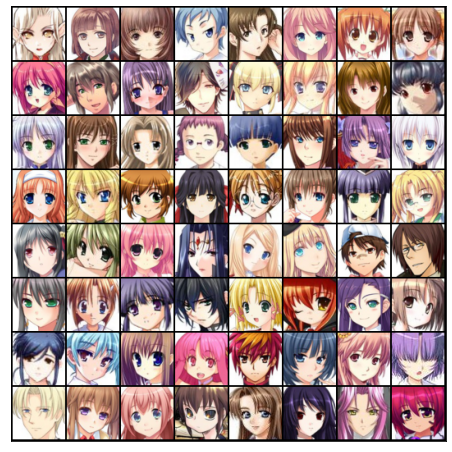

In [10]:
# show few samples of the first batch of train loader
show_batch(dl=train_dl)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
import torch.nn as nn

In [13]:
discriminator = nn.Sequential(
    # input : bs x 3 x 64 x 64

    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=64),
    nn.LeakyReLU(negative_slope=.2, inplace=True),
    # bs x 64 x 32 x 32

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=128),
    nn.LeakyReLU(negative_slope=.2, inplace=True),
    # bs x 128 x 16 x 16

    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=256),
    nn.LeakyReLU(negative_slope=.2, inplace=True),
    # bs x 256 x 8 x 8

    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=512),
    nn.LeakyReLU(negative_slope=.2, inplace=True),
    # bs x 512 x 4 x 4

    nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=2, padding=0, bias=False),
    # bs x 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
).to(device)

# check if discriminator is already in gpu or not
next(discriminator.parameters()).is_cuda

True

In [14]:
# latent size matters for details in the output of generator 
LATENT_SIZE = 128

generator = nn.Sequential(
    # bs x LATENT_SIZE x 1 x 1

    nn.ConvTranspose2d(in_channels=LATENT_SIZE, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(num_features=512),
    nn.ReLU(inplace=True),
    # bs x 512 x 4 x 4

    nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=256),
    nn.ReLU(inplace=True),
    # bs x 256 x 8 x 8

    nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=128),
    nn.ReLU(inplace=True),
    # bs x 128 x 16 x 16

    nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(inplace=True),
    # bs x 64 x 32 x 32

    nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh(),
    # bs x 3 x 64 x 64
).to(device)

# check if generator is already in gpu or not
next(generator.parameters()).is_cuda

True

In [15]:
from torchvision.utils import save_image

sample_dir = 'generated_images'
os.makedirs(sample_dir, exist_ok=True)

def save_sample(index, latent_tensors, nmax=64,show=True):
    fake_images = generator(latent_tensors)
    fake_name = f'generated_image_{index}.png'
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_name), nrow=8)
    print(fake_name, ' saved')
    if show:
        show_images(fake_images.cpu())

generated_image_0.png  saved


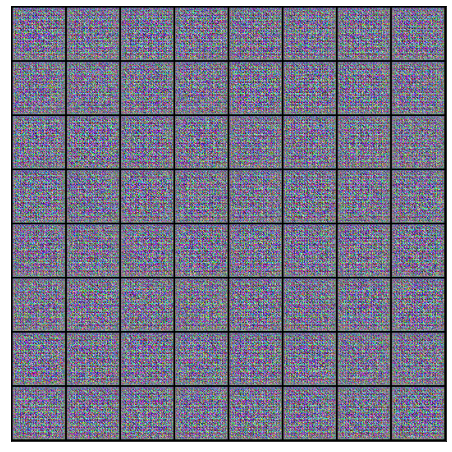

In [16]:
# create a fixed latent and display it
fixed_latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
save_sample(0, fixed_latent)

In [17]:
from torch.nn.functional import binary_cross_entropy
import torch.optim as optim
import numpy as np, time

In [18]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    real_preds = discriminator(real_images.to(device))
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
    fake_images = generator(latent)

    fake_preds = discriminator(fake_images.to(device))
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()

    return loss.item(), real_score, fake_score

In [19]:
def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
    fake_images = generator(latent)

    fake_preds = discriminator(fake_images.to(device))
    fake_targets = torch.ones(fake_images.size(0), 1, device=device)
    fake_loss = binary_cross_entropy(fake_preds, fake_targets)

    fake_loss.backward()
    opt_g.step()

    return fake_loss.item()

In [20]:
opt_d = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))
opt_g = torch.optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))

In [21]:
import time
import numpy as np

Epoch: 1, loss_d: 1.02, loss_g: 4.98, real_score: 0.77, fake_score: 0.25
Time Elapsed: 2.14 Minutes
generated_image_1.png  saved


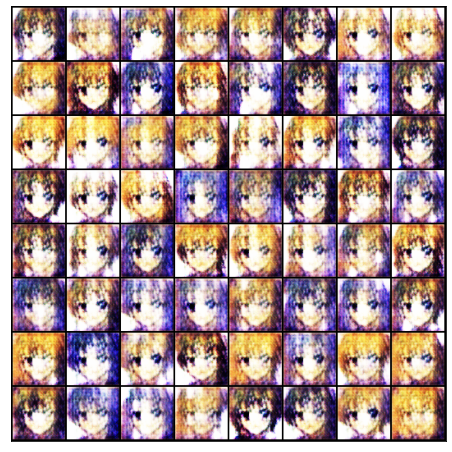



Epoch: 2, loss_d: 0.78, loss_g: 5.50, real_score: 0.80, fake_score: 0.21
Time Elapsed: 2.13 Minutes
generated_image_2.png  saved


Epoch: 3, loss_d: 0.68, loss_g: 6.22, real_score: 0.82, fake_score: 0.18
Time Elapsed: 2.13 Minutes
generated_image_3.png  saved


Epoch: 4, loss_d: 0.57, loss_g: 6.94, real_score: 0.84, fake_score: 0.15
Time Elapsed: 2.12 Minutes
generated_image_4.png  saved


Epoch: 5, loss_d: 0.48, loss_g: 7.39, real_score: 0.87, fake_score: 0.13
Time Elapsed: 2.13 Minutes
generated_image_5.png  saved


Epoch: 6, loss_d: 0.43, loss_g: 7.76, real_score: 0.88, fake_score: 0.12
Time Elapsed: 2.12 Minutes
generated_image_6.png  saved


Epoch: 7, loss_d: 0.41, loss_g: 7.77, real_score: 0.88, fake_score: 0.12
Time Elapsed: 2.12 Minutes
generated_image_7.png  saved


Epoch: 8, loss_d: 0.35, loss_g: 7.70, real_score: 0.90, fake_score: 0.10
Time Elapsed: 2.12 Minutes
generated_image_8.png  saved


Epoch: 9, loss_d: 0.35, loss_g: 8.35, real_score: 0.90, fake_score: 0.10
Time Ela

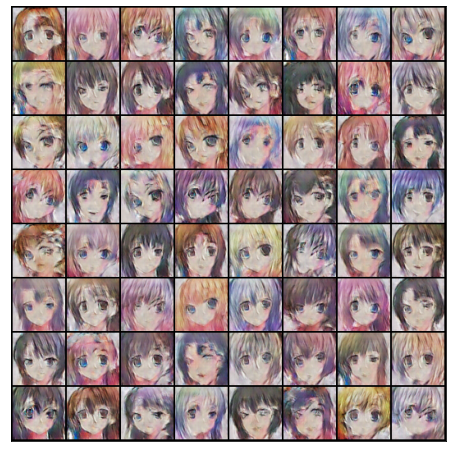



Epoch: 12, loss_d: 0.30, loss_g: 8.13, real_score: 0.91, fake_score: 0.09
Time Elapsed: 2.12 Minutes
generated_image_12.png  saved


Epoch: 13, loss_d: 0.30, loss_g: 8.00, real_score: 0.92, fake_score: 0.08
Time Elapsed: 2.12 Minutes
generated_image_13.png  saved


Epoch: 14, loss_d: 0.31, loss_g: 7.76, real_score: 0.92, fake_score: 0.08
Time Elapsed: 2.11 Minutes
generated_image_14.png  saved


Epoch: 15, loss_d: 0.30, loss_g: 7.55, real_score: 0.92, fake_score: 0.08
Time Elapsed: 2.12 Minutes
generated_image_15.png  saved


Epoch: 16, loss_d: 0.35, loss_g: 7.15, real_score: 0.91, fake_score: 0.09
Time Elapsed: 2.12 Minutes
generated_image_16.png  saved


Epoch: 17, loss_d: 0.28, loss_g: 7.35, real_score: 0.92, fake_score: 0.08
Time Elapsed: 2.12 Minutes
generated_image_17.png  saved


Epoch: 18, loss_d: 0.30, loss_g: 7.65, real_score: 0.92, fake_score: 0.08
Time Elapsed: 2.11 Minutes
generated_image_18.png  saved


Epoch: 19, loss_d: 0.28, loss_g: 7.18, real_score: 0.92, fake_score

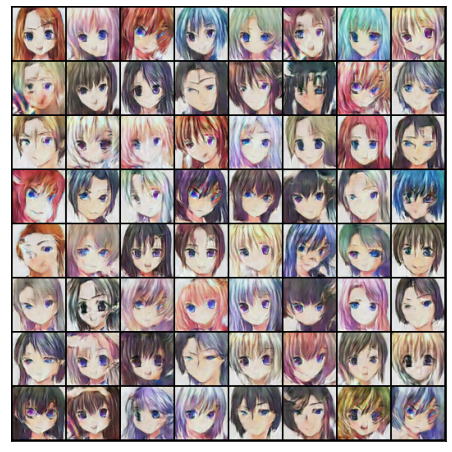



Epoch: 22, loss_d: 0.25, loss_g: 6.99, real_score: 0.93, fake_score: 0.07
Time Elapsed: 2.11 Minutes
generated_image_22.png  saved


Epoch: 23, loss_d: 0.27, loss_g: 7.20, real_score: 0.93, fake_score: 0.07
Time Elapsed: 2.11 Minutes
generated_image_23.png  saved


Epoch: 24, loss_d: 0.32, loss_g: 6.99, real_score: 0.92, fake_score: 0.08
Time Elapsed: 2.11 Minutes
generated_image_24.png  saved


Epoch: 25, loss_d: 0.26, loss_g: 6.63, real_score: 0.93, fake_score: 0.07
Time Elapsed: 2.11 Minutes
generated_image_25.png  saved


Epoch: 26, loss_d: 0.25, loss_g: 6.55, real_score: 0.93, fake_score: 0.07
Time Elapsed: 2.11 Minutes
generated_image_26.png  saved


Epoch: 27, loss_d: 0.29, loss_g: 6.50, real_score: 0.93, fake_score: 0.07
Time Elapsed: 2.11 Minutes
generated_image_27.png  saved


Epoch: 28, loss_d: 0.29, loss_g: 6.37, real_score: 0.93, fake_score: 0.07
Time Elapsed: 2.11 Minutes
generated_image_28.png  saved


Epoch: 29, loss_d: 0.26, loss_g: 6.17, real_score: 0.93, fake_score

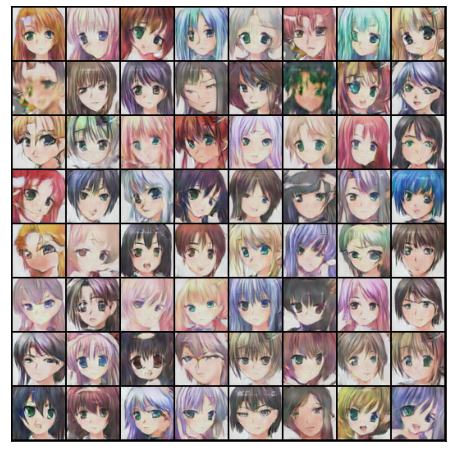



Epoch: 32, loss_d: 0.21, loss_g: 6.34, real_score: 0.94, fake_score: 0.06
Time Elapsed: 2.12 Minutes
generated_image_32.png  saved


Epoch: 33, loss_d: 0.28, loss_g: 6.38, real_score: 0.93, fake_score: 0.07
Time Elapsed: 2.11 Minutes
generated_image_33.png  saved


Epoch: 34, loss_d: 0.34, loss_g: 6.08, real_score: 0.92, fake_score: 0.08
Time Elapsed: 2.11 Minutes
generated_image_34.png  saved


Epoch: 35, loss_d: 0.19, loss_g: 5.90, real_score: 0.95, fake_score: 0.05
Time Elapsed: 2.11 Minutes
generated_image_35.png  saved


Epoch: 36, loss_d: 0.26, loss_g: 6.46, real_score: 0.93, fake_score: 0.07
Time Elapsed: 2.11 Minutes
generated_image_36.png  saved


Epoch: 37, loss_d: 0.29, loss_g: 6.12, real_score: 0.94, fake_score: 0.06
Time Elapsed: 2.12 Minutes
generated_image_37.png  saved


Epoch: 38, loss_d: 0.28, loss_g: 5.85, real_score: 0.93, fake_score: 0.07
Time Elapsed: 2.11 Minutes
generated_image_38.png  saved


Epoch: 39, loss_d: 0.23, loss_g: 5.65, real_score: 0.94, fake_score

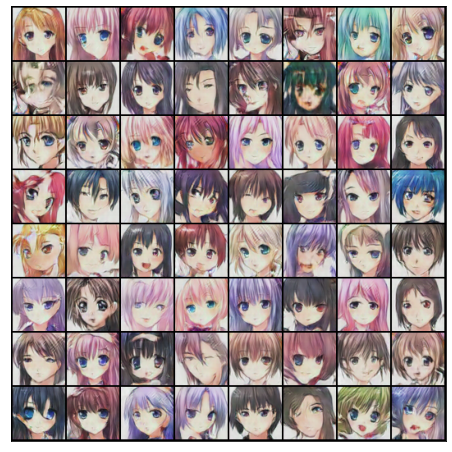



Epoch: 42, loss_d: 0.25, loss_g: 6.07, real_score: 0.94, fake_score: 0.06
Time Elapsed: 2.12 Minutes
generated_image_42.png  saved


Epoch: 43, loss_d: 0.31, loss_g: 6.07, real_score: 0.93, fake_score: 0.07
Time Elapsed: 2.11 Minutes
generated_image_43.png  saved


Epoch: 44, loss_d: 0.20, loss_g: 5.95, real_score: 0.95, fake_score: 0.05
Time Elapsed: 2.11 Minutes
generated_image_44.png  saved


Epoch: 45, loss_d: 0.12, loss_g: 6.02, real_score: 0.96, fake_score: 0.04
Time Elapsed: 2.11 Minutes
generated_image_45.png  saved


Epoch: 46, loss_d: 0.35, loss_g: 6.04, real_score: 0.93, fake_score: 0.07
Time Elapsed: 2.12 Minutes
generated_image_46.png  saved


Epoch: 47, loss_d: 0.15, loss_g: 5.83, real_score: 0.96, fake_score: 0.04
Time Elapsed: 2.11 Minutes
generated_image_47.png  saved


Epoch: 48, loss_d: 0.32, loss_g: 6.16, real_score: 0.93, fake_score: 0.07
Time Elapsed: 2.11 Minutes
generated_image_48.png  saved


Epoch: 49, loss_d: 0.17, loss_g: 5.60, real_score: 0.95, fake_score

In [22]:
for epoch in range(EPOCHS):
    start = time.time()
    torch.cuda.empty_cache()

    losses_d = []
    losses_g = []
    real_scores = []
    fake_scores = []

    for real_images, _ in train_dl:
        loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
        loss_g = train_generator(opt_g)

        losses_d.append(loss_d)
        losses_g.append(loss_g)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
    
    mean_loss_d = np.sum(losses_d) / len(losses_d)
    mean_loss_g = np.sum(losses_g) / len(losses_g)
    mean_real_scores = np.sum(real_scores) / len(real_scores)
    mean_fake_scores = np.sum(fake_scores) / len(fake_scores)
    end = time.time()

    print(f'Epoch: {epoch+1}, loss_d: {mean_loss_d:.2f}, loss_g: {mean_loss_g:.2f}, real_score: {mean_real_scores:.2f}, fake_score: {mean_fake_scores:.2f}')
    print(f'Time Elapsed: {(end-start)/60:.2f} Minutes')
    
    # save each generated sample after every epoch but show them once after 10 epoch to reduce the notebook's size
    if epoch % 10 == 0:
        save_sample(epoch+1, fixed_latent, show=True)
    else:
        save_sample(epoch+1, fixed_latent, show=False)
    print('\n')

In [23]:
save_d_at = '/content/drive/MyDrive/GANs/Image Generation/driscriminator.pth'
save_g_at = '/content/drive/MyDrive/GANs/Image Generation/generator.pth'

In [24]:
# save the models for futher use
torch.save(discriminator.state_dict(), save_d_at)
torch.save(generator.state_dict(), save_g_at)
print('Discriminator and Generator models saved at google drive')

Discriminator and Generator models saved at google drive
